In [53]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
thetadata_start = '2021-01-01'

In [55]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
key = 8
with open(f'../input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# AMZN20220329LONG
# ttrades__ = ttrades__[ttrades__.index.isin([26,])]
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,60,506,547,129.341114,120.980003,-501.666662,-0.064644,2021-01-05,2021-03-05,59,AAPL
1,29,506,594,242.064271,200.830002,-1195.793812,-0.170344,2021-01-05,2021-05-12,127,TSLA
2,10,518,549,584.137326,507.309998,-768.273279,-0.131523,2021-01-22,2021-03-09,46,NFLX
3,1362,536,547,14.780552,12.550000,-3038.011008,-0.150911,2021-02-18,2021-03-05,15,NVDA
4,20,551,595,249.640699,223.000000,-532.813986,-0.106716,2021-03-11,2021-05-13,63,BA
5,1347,552,561,12.692518,12.499500,-259.995549,-0.015207,2021-03-12,2021-03-25,13,NVDA
6,58,554,557,126.139947,119.900002,-361.916834,-0.049468,2021-03-16,2021-03-19,3,AAPL
7,56,559,561,123.761657,119.540001,-236.412732,-0.034111,2021-03-23,2021-03-25,2,AAPL
8,7,559,709,294.176019,320.299988,182.867782,0.088804,2021-03-23,2021-10-25,216,META
9,1307,564,756,12.886947,29.674000,21940.677982,1.302640,2021-03-30,2021-12-31,276,NVDA


In [56]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)


max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash
pd.Series(weights).sort_values(ascending=False), max_cash

(NVDA    0.270951
 AMD     0.160574
 AAPL    0.106024
 TSLA    0.095968
 AMZN    0.092015
 NFLX    0.082209
 BA      0.068481
 SBUX    0.050504
 COST    0.042683
 META    0.030590
 dtype: float64,
 {'NVDA': 2,
  'AMD': 2,
  'TSLA': 2,
  'AAPL': 2,
  'NFLX': 2,
  'AMZN': 2,
  'BA': 2,
  'META': 2,
  'SBUX': 2,
  'COST': 2})

In [57]:

# from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
# from pandas.tseries.offsets import BDay

# rm = RiskManager(None, None, 1000000)
# rm.OrderPicker.liquidity_threshold = 2
# rm.OrderPicker.lookback = 10
# rm.OrderPicker.data_availability_threshold = 0.15
# date, tick = '2023-07-05', 'AVGO'
# date, tick = '2024-08-13', 'TSM'
# start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
# right = 'C'
# order_settings = {'type': 'spread',
#  'specifics': [{'direction': 'long',
#    'rel_strike': .50,
#    'dte': 210,
#    'moneyness_width': 0.5},
#   #  {'direction': 'short',
#   # 'rel_strike': .60,
#   # 'dte': 270,
#   # 'moneyness_width': 0.35}
# ],
#  'name': 'vertical_spread'}



# order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
# order

In [58]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

pd.options.display.max_rows = 15
pd.options.display.max_columns = 15

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)
evb_backtest.portfolio.initial_capital
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .90,
   'dte': 365,
   'moneyness_width': 0.150},
   {'direction': 'short',
  'rel_strike': .85,
  'dte': 365,
  'moneyness_width': 0.150}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.min_moneyness_threshold = 4
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 30
evb_backtest.portfolio.dte_reduction_factor = 60

for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])



signals = evb_backtest.bars.signal_df
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

28.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [59]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['AAPL20220121C165'], 'short': ['AAPL20220121C175'], 'trade_id': '&L:AAPL20220121C165&S:AAPL20220121C175', 'close': 1.825000000000001}, Date: 2021-01-05, Signal: SignalEvent type:LONG, symbol=AAPL, date:2021-01-05 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:AAPL20210105LONG
Max Contract Price: 2, Cash at Hand: 16.221661856561585
Cash at Hand 16.221661856561585 Close 1.825000000000001
Processing event: SIGNAL
Not generating order because:MAX_PRICE_TOO_LOW at 2, adjusted to 2.4 SignalEvent type:LONG, symbol=TSLA, date:2021-01-05 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:TSLA20210105LONG 
Processing event: ORDER
Buy Order Position: {'long': ['AAPL20220121C165'], 'short': ['AAPL20220121C175'], 'trade_id': '&L:AAPL20220121C165&S:AAPL20220121C175', 'close': 1.825000000000001} Price: 1.9048620569607808 Quantity: 8 Datetime: 2021-01-05 00:00:00
Processing event: SIGNAL

In [60]:
pd.set_option('display.max_rows', 100)
transactions=evb_backtest.portfolio.transactions
transactions[transactions.symbol=='COST']

,signal_id,datetime,symbol,direction,cash_before,cash_after
17,COST20210416LONG,2021-04-16,COST,BUY,725.609031,105.560166
46,COST20210416LONG,2021-12-23,COST,SELL,105.560166,3001.469749
47,COST20210416LONG,2021-12-23,COST,BUY,3001.469749,1132.121607
49,COST20210416LONG,2021-12-31,COST,SELL,1132.121607,2927.896789


In [61]:
from EventDriven.execution import exec_cache
idx = 10
buys = [x  for x in exec_cache['fill'].values() if x.direction == 'BUY']
buy1 = buys[idx]
print("Buy")
print(buy1.datetime,buy1.fill_cost/buy1.quantity, buy1.market_value)

sells = [x  for x in exec_cache['fill'].values() if x.direction == 'SELL']
sell1 = sells[idx]
print("Sell")
print(sell1.datetime,sell1.fill_cost/sell1.quantity, sell1.market_value, len(exec_cache['fill']))


Buy
2021-04-14 00:00:00 5.964421555554731 11.902843111109462
Sell
2021-05-19 00:00:00 1.8560147321774683 3.7380294643549363 57


In [62]:
tsla_buys = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'BUY']
tsla_sells = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'SELL']
tsla_buys, tsla_sells

([<EventDriven.event.FillEvent at 0x1401c90d0>,
  <EventDriven.event.FillEvent at 0x141507f50>])

In [63]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
# len(trades['SignalID'].unique())
trades#[['Positions','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']]
trades#[['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue']]

,Ticker,PnL,ReturnPct,EntryPrice,EntryCommission,EntrySlippage,EntryMarketValue,TotalEntryCost,AuxilaryEntryCost,ExitPrice,ExitCommission,ExitSlippage,ExitMarketValue,TotalExitCost,AuxilaryExitCost,Quantity,EntryTime,ExitTime,Duration,Positions,SignalID
0,AAPL,-765.106201,-0.498671,191.786206,10.4,63.889646,1523.889646,15.342896,74.289646,96.147931,10.4,-40.416555,779.583445,7.691834,50.816555,8,2021-01-05,2021-03-05,59,&L:AAPL20220121C165&S:AAPL20220121C175,AAPL20210105LONG
1,TSLA,-761.717580,-0.523645,242.441009,7.8,81.846056,1446.846056,14.546461,89.646056,115.488079,7.8,-34.271524,700.728476,6.929285,42.071524,6,2021-01-05,2021-05-12,127,&L:TSLA20220121C920&S:TSLA20220121C930,TSLA20210105LONG
2,NFLX,-434.921558,-0.365950,1188.473868,1.3,37.173868,1187.173868,11.884739,38.473868,753.552310,1.3,-22.647690,754.852310,7.535523,23.947690,1,2021-01-22,2021-03-09,46,&L:NFLX20220121C660&S:NFLX20220121C700,NFLX20210122LONG
3,NVDA,-2186.705604,-0.584506,467.639959,10.4,190.719672,3730.719672,37.411197,201.119672,194.301758,10.4,-55.185933,1564.814067,15.544141,65.585933,8,2021-02-18,2021-03-05,15,&L:NVDA20220121C740&S:NVDA20220121C760,NVDA20210218LONG
4,BA,-700.193592,-0.827959,211.421698,5.2,50.486792,840.486792,8.456868,55.686792,36.373300,5.2,-9.306800,150.693200,1.454932,14.506800,4,2021-03-11,2021-05-13,63,&L:BA20220121C325&S:BA20220121C335,BA20210311LONG
5,NVDA,-528.683137,-0.283573,372.872964,6.5,120.364820,1857.864820,18.643648,126.864820,267.136337,6.5,-45.318316,1342.181684,13.356817,51.818316,5,2021-03-12,2021-03-25,13,&L:NVDA20220121C680&S:NVDA20220121C700,NVDA20210312LONG
6,AAPL,-271.811664,-0.315011,215.715770,5.2,57.663082,857.663082,8.628631,62.863082,147.762854,5.2,-33.748583,596.251417,5.910514,38.948583,4,2021-03-16,2021-03-19,3,&L:AAPL20220121C160&S:AAPL20220121C175,AAPL20210316LONG
7,AAPL,-112.584172,-0.184985,202.870747,3.9,34.712240,604.712240,6.086122,38.612240,165.342690,3.9,-25.071931,499.928069,4.960281,28.971931,3,2021-03-23,2021-03-25,2,&L:AAPL20220121C145&S:AAPL20220121C155,AAPL20210323LONG
8,NVDA,2907.925199,1.974814,368.126430,5.2,97.305720,1467.305720,14.725057,102.505720,1095.107730,5.2,-274.369080,4385.630920,43.804309,279.569080,4,2021-03-30,2021-12-22,267,&L:NVDA20220121C680&S:NVDA20220121C700,NVDA20210330LONG
9,AAPL,-88.762511,-0.223562,198.518642,2.6,9.437284,394.437284,3.970373,12.037284,154.137386,2.6,-9.125227,310.874773,3.082748,11.725227,2,2021-04-06,2021-05-13,37,&L:AAPL20220617C165&S:AAPL20220617C180,AAPL20210406LONG


In [64]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{'type': 'SIGNAL', 'symbol': 'META', 'datetime': Timestamp('2021-03-23 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'META20210323LONG', 'max_contract_price': None, 'order_settings': None, 'reason': 'UNAVAILABLE_CONTRACT'}
{'type': 'SIGNAL', 'symbol': 'META', 'datetime': Timestamp('2021-11-16 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'META20211116LONG', 'max_contract_price': None, 'order_settings': {'type': 'naked', 'specifics': [{'direction': 'long', 'rel_strike': 0.85, 'dte': 125, 'moneyness_width': 0.1}, {'direction': 'short', 'rel_strike': 0.75, 'dte': 125, 'moneyness_width': 0.1}], 'name': 'vertical_spread'}, 'reason': 'TOO_ILLIQUID'}
{'type': 'SIGNAL', 'symbol': 'AMZN', 'datetime': Timestamp('2021-11-18 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'AMZN20211118LONG', 'max_contract_price': None, 'order_settings': {'type': 'naked', 'specifics': [{'direction': 'long', 'rel_strike': 0.85, 'dte': 125, 'moneyness_width': 0.1}, {'direction': 'short', 'rel_strike': 0.75, 'dte'

{'UNAVAILABLE_CONTRACT': 1, 'TOO_ILLIQUID': 2}

<Axes: xlabel='datetime'>

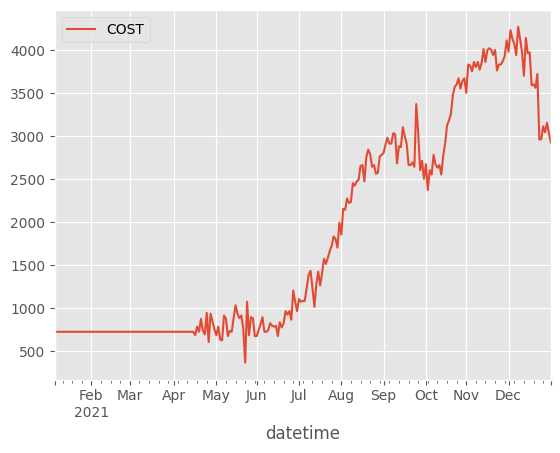

In [65]:
evb_backtest.portfolio._equity.plot(y = 'COST')

In [66]:
evb_backtest.portfolio.plot_portfolio()

In [67]:
evb_backtest.portfolio.aggregate()

Start                                                    2021-01-05 00:00:00
End                                                      2021-12-31 00:00:00
Duration                                                   360 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                     21276.9
Equity Peak [$]                                                 23898.327774
Return [%]                                                           7.26374
Buy & Hold Return [%]                                              32.883784
CAGR [%]                                                            7.368255
Volatility Ann. [%]                                                44.224604
Sharpe Ratio                                                        0.382143
Sortino Ratio                                                       0.532585
Skew                                                               -0.226625

In [68]:
#&L:COST20230120C680&S:COST20230120C700
# 9	2022-01-11	COST	BUY	989.300187	165.485214
# 12	2022-01-21	COST	SELL	165.485214	33.494091
# &L:AAPL20230120C240&S:AAPL20230120C260	2022-01-04	2022-01-19
price_data = evb_backtest.portfolio.options_data['COST20230120C680'] - evb_backtest.portfolio.options_data['COST20230120C700']
price_data.plot(y = 'Midpoint')
price_data[(price_data.index >= '2022-01-04') & (price_data.index <= '2022-01-25')]
# price_data[price_data.index.isin(['2022-01-04', '2022-01-21'])]

KeyError: 'COST20230120C680'

In [156]:
price_data

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2022-01-04,2.85,2.10,3.55,3.25,-100,50,1.75,39,4.95,3.350,3.042473
2022-01-05,4.10,3.80,5.10,4.75,-27,-41,3.50,61,5.35,4.425,6.236236
2022-01-06,4.41,4.14,4.41,4.19,-6,17,3.30,1,3.35,3.325,3.304925
2022-01-07,1.24,1.62,2.92,2.80,-7,55,2.40,4,2.90,2.650,2.180994
2022-01-10,1.99,2.46,2.36,1.98,-116,-33,1.85,0,2.15,2.000,2.047370
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.00,0.00,0.00,0.00,0,0,0.00,0,0.00,0.000,0.000000
2022-12-27,-0.01,-0.01,-0.01,-0.01,-10,0,0.00,3,0.03,0.015,0.030000
2022-12-28,0.00,0.00,0.00,0.00,0,0,0.00,-4,0.00,0.000,0.000000


In [152]:
(1.235/1.950)-1

-0.3666666666666666

In [63]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                short  \
datetime   symbol                                             
2022-01-04 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-05 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-06 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-07 AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-10 AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-11 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-12 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-13 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-14 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-17 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-18 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-19 COST     [COST20230120C680]   [COST20230120C700]   
2022-01-20 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-21 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-24 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-25 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-26 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-27 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-28 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-31 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-02-01 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-02 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-03 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-04 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-07 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
20

In [64]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

In [65]:
order_cache['2024-01-03']

KeyError: '2024-01-03'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [89]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')

AttributeError: 'OptionSignalBacktest' object has no attribute 'trades'